# 기본 패키지 설정

In [186]:
import numpy as np
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 데이터 읽기

In [187]:
df = pd.read_csv("baseline_data.csv", index_col=['Date'], parse_dates=True)

In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4103 entries, 2005-01-04 to 2021-08-13
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        4103 non-null   float64
 1   High        4103 non-null   float64
 2   Low         4103 non-null   float64
 3   Close       4103 non-null   float64
 4   Adj Close   4103 non-null   float64
 5   Volume      4103 non-null   int64  
 6   next_price  4102 non-null   float64
 7   next_rtn    4103 non-null   float64
 8   log_return  4102 non-null   float64
 9   CCI         4090 non-null   float64
 10  MA5         4099 non-null   float64
 11  MA10        4094 non-null   float64
 12  RASD5       4095 non-null   float64
 13  RASD10      4090 non-null   float64
 14  MACD        4070 non-null   float64
 15  ATR         4089 non-null   float64
 16  ub          4084 non-null   float64
 17  middle      4084 non-null   float64
 18  lb          4084 non-null   float64
 19  MTM1     

# 결측치 제거

In [190]:
df.isnull().sum()

Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
next_price      1
next_rtn        0
log_return      1
CCI            13
MA5             4
MA10            9
RASD5           8
RASD10         13
MACD           33
ATR            14
ub             19
middle         19
lb             19
MTM1            1
MTM3            3
ROC            60
WPR            13
S&P500        124
SOX           125
VIX           125
KOSPI          20
dtype: int64

In [191]:
df = df.dropna()
df = df.loc['2011':'2020']

In [192]:
df.isnull().sum()

Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
next_price    0
next_rtn      0
log_return    0
CCI           0
MA5           0
MA10          0
RASD5         0
RASD10        0
MACD          0
ATR           0
ub            0
middle        0
lb            0
MTM1          0
MTM3          0
ROC           0
WPR           0
S&P500        0
SOX           0
VIX           0
KOSPI         0
dtype: int64

In [195]:
df.shape

(2361, 27)

# 라벨링

In [197]:
df['next_price'] = df['Close'].shift(-7)
diffs = df['next_price']-df['Close']
df['label'] = np.where(diffs>0,1,0)

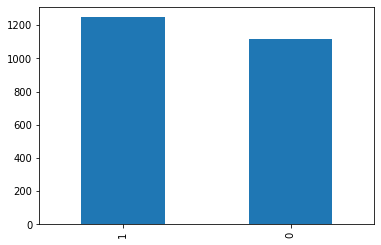

In [198]:
df['label'].value_counts().plot.bar()

In [199]:
X = df.drop(['next_price', 'label'], axis=1)
y = df['label']

In [200]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2361 entries, 2011-01-03 to 2020-12-30
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        2361 non-null   float64
 1   High        2361 non-null   float64
 2   Low         2361 non-null   float64
 3   Close       2361 non-null   float64
 4   Adj Close   2361 non-null   float64
 5   Volume      2361 non-null   int64  
 6   next_rtn    2361 non-null   float64
 7   log_return  2361 non-null   float64
 8   CCI         2361 non-null   float64
 9   MA5         2361 non-null   float64
 10  MA10        2361 non-null   float64
 11  RASD5       2361 non-null   float64
 12  RASD10      2361 non-null   float64
 13  MACD        2361 non-null   float64
 14  ATR         2361 non-null   float64
 15  ub          2361 non-null   float64
 16  middle      2361 non-null   float64
 17  lb          2361 non-null   float64
 18  MTM1        2361 non-null   float64
 19  MTM3     

# 전처리

In [201]:
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

scaler = MinMaxScaler()
le = LabelEncoder()

scaler.fit(X)
X_scaled = scaler.transform(X)
y = le.fit_transform(y)

In [202]:
sum(y)/len(df)*100

52.81660313426514

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1234, shuffle=True, stratify=y)

# 개별 ML 모델을 위한 Classifier 생성.
rf_clf = RandomForestClassifier(criterion='entropy',n_estimators=700,random_state=1234) #랜덤포레스트
tree = DecisionTreeClassifier(max_depth=4,criterion='entropy',random_state=1234)
ada_clf = AdaBoostClassifier(base_estimator=tree, 
                                n_estimators=100,
                                learning_rate = 0.01, 
                                random_state=1234) #아다부스트
lgb_clf = LGBMClassifier(random_state=1234)
xgb_clf = XGBClassifier(tree_method='hist',random_state=1234)

# 개별 모델들을 학습. 
rf_clf.fit(X_train , y_train)  
ada_clf.fit(X_train, y_train)
lgb_clf.fit(X_train, y_train)
xgb_clf.fit(X_train , y_train)

# 학습된 개별 모델들이 각자 반환하는 예측 데이터 셋을 생성하고 개별 모델의 정확도 측정. 
rf_pred = rf_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)
lgb_pred = lgb_clf.predict(X_test)
xgb_pred = xgb_clf.predict(X_test)

print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))
print('LGB 정확도: {0:.4f}'.format(accuracy_score(y_test, lgb_pred)))
print('XGB 정확도: {0:.4f}'.format(accuracy_score(y_test, xgb_pred)))

랜덤 포레스트 정확도: 0.8055
에이다부스트 정확도: 0.7188
LGB 정확도: 0.7928
XGB 정확도: 0.6956


# Stacking

In [204]:
# 시험데이터로 예측한 4가지 모델의 결과를 합침
pred = np.array([rf_pred, ada_pred, lgb_pred, xgb_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 컬럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦. 
pred = np.transpose(pred)
print(pred.shape)

# 최종 분류기 모델 생성
lr_final = LogisticRegression(C=10)

# 최종 분류기 학습 및 예측
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test , final)))

(4, 473)
(473, 4)
최종 메타 모델의 예측 정확도: 0.8055


# Kfold 기반 Stacking

In [205]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score

In [206]:
# 스태킹 함수
def get_stacking_datasets(model, Xtrain, ytrain, Xtest, n_folds=5):
  # cv하기 위해 K-fold 설정
  kfold = KFold(n_splits=n_folds, shuffle=True, random_state=1234)

  # 최종 메타 모델이 사용할 학습 데이터 반환을 위해서 넘파이 배열을 0으로 만들어서 초기화
  train_fold_pred = np.zeros((X_train.shape[0], 1)) # 2차원
  test_pred = np.zeros((Xtest.shape[0], n_folds))
  print('model: ', model.__class__.__name__)

  for cnt, (train_index, valid_index) in enumerate(kfold.split(Xtrain)):
    # 개별 모델 내부에서 학습하고 1개의 fold로 예측할 데이터셋 추출
    print(f" Fold 횟수 : {cnt+1}")
    x_tr = Xtrain[train_index]
    y_tr = ytrain[train_index]
    x_te = Xtrain[valid_index]

    # 학습
    model.fit(x_tr, y_tr)
    # 1개의 fold데이터셋으로 예측값 반환 후 최종 메타모델이 학습할 데이터셋에 첨가
    train_fold_pred[valid_index, :] = model.predict(x_te).reshape(-1, 1)
    # 해당 폴드에서 생성된 모델에게 원본 테스트 데이터(Xtest)를 이용해서 예측을 수행하고 저장
    test_pred[:, cnt] = model.predict(Xtest)

  # 개별 모델 안에서 테스트 데이터셋을 기반으로 예측한 결과값들 mean취해주고 2차원으로 바꾸기
  test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)

  return train_fold_pred, test_pred_mean


In [207]:
rf_train, rf_test = get_stacking_datasets(rf_clf, X_train, y_train, X_test, 5)
ada_train, ada_test = get_stacking_datasets(ada_clf, X_train, y_train, X_test, 5)
lgb_train, lgb_test = get_stacking_datasets(lgb_clf, X_train, y_train, X_test, 5)
xgb_train, xgb_test = get_stacking_datasets(xgb_clf, X_train, y_train, X_test, 5)

model:  RandomForestClassifier
 Fold 횟수 : 1
 Fold 횟수 : 2
 Fold 횟수 : 3
 Fold 횟수 : 4
 Fold 횟수 : 5
model:  AdaBoostClassifier
 Fold 횟수 : 1
 Fold 횟수 : 2
 Fold 횟수 : 3
 Fold 횟수 : 4
 Fold 횟수 : 5
model:  LGBMClassifier
 Fold 횟수 : 1
 Fold 횟수 : 2
 Fold 횟수 : 3
 Fold 횟수 : 4
 Fold 횟수 : 5
model:  XGBClassifier
 Fold 횟수 : 1
 Fold 횟수 : 2
 Fold 횟수 : 3
 Fold 횟수 : 4
 Fold 횟수 : 5


In [208]:
stack_final_x_train = np.concatenate((rf_train, ada_train, lgb_train, xgb_train), axis=1)
stack_final_x_test = np.concatenate((rf_test, ada_test, lgb_test, xgb_test), axis=1)

#최종 메타모델로 학습
lr_final.fit(stack_final_x_train, y_train)
stack_final_pred = lr_final.predict(stack_final_x_test)

#최종 메타모델 성능 평가
print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test , stack_final_pred)))

최종 메타 모델의 예측 정확도: 0.8076
